In [1]:
!date

Sun Mar  1 23:54:21 PST 2020


# Bad gene matrix creation

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
adata = "/home/sina/projects/mop/mop_SMARTseq/out_cr_index/annotated_adata.h5ad"
adata = anndata.read_h5ad(adata)
adata.var["gene_name"] = adata.var["gene_name"].astype(str) + "_" + adata.var.gene_id.astype(str)
adata.var["transcript_name"] = adata.var["transcript_name"].astype(str) + "_" + adata.var.transcript_id.astype(str)

Transforming to str index.


In [3]:
def change(x):
    if x=="L5 ET": return "L5 PT"
    return x

In [4]:
adata.obs.subclass_label.value_counts()

L5 IT          1571
L6 CT           904
Vip             659
L6b             571
Pvalb           543
L2/3 IT         483
Sst             427
L6 IT           395
Lamp5           377
L5/6 NP         208
Sncg             84
SMC              21
L5 ET            12
Low Quality      12
Astro            10
Endo              7
VLMC              6
L6 IT Car3        5
Name: subclass_label, dtype: int64

In [5]:
adata.obs.cluster_label = adata.obs.cluster_label.apply(change).values
adata.obs.subclass_label = adata.obs.subclass_label.apply(change).values

In [6]:
adata.obs.subclass_label.value_counts()

L5 IT          1571
L6 CT           904
Vip             659
L6b             571
Pvalb           543
L2/3 IT         483
Sst             427
L6 IT           395
Lamp5           377
L5/6 NP         208
Sncg             84
SMC              21
L5 PT            12
Low Quality      12
Astro            10
Endo              7
VLMC              6
L6 IT Car3        5
Name: subclass_label, dtype: int64

In [7]:
lengths = pd.read_csv("/home/sina/projects/mop/reference/cellranger_index/refdata-cellranger-mm10-3.0.0/kb_out/length_info.txt", header=None, names=["length", "transcript_id", "gene_id", "gene_name", "transcript_name", "chr", "start", "end", "strand"], sep="\t")
lengths["transcript_id"] = lengths["transcript_id"].apply(lambda x: x.split(".")[0])
lengths.index = lengths.transcript_id.values

In [8]:
adata.var["length"] = adata.var.transcript_id.map(lengths["length"])

In [9]:
adata.var.head()

,transcript_id,gene_id,gene_name,transcript_name,length
0,ENSMUST00000162897,ENSMUSG00000051951,Xkr4_ENSMUSG00000051951,Xkr4-203_ENSMUST00000162897,4153
1,ENSMUST00000159265,ENSMUSG00000051951,Xkr4_ENSMUSG00000051951,Xkr4-202_ENSMUST00000159265,2989
2,ENSMUST00000070533,ENSMUSG00000051951,Xkr4_ENSMUSG00000051951,Xkr4-201_ENSMUST00000070533,3634
3,ENSMUST00000161581,ENSMUSG00000089699,Gm1992_ENSMUSG00000089699,Gm1992-201_ENSMUST00000161581,250
4,ENSMUST00000194643,ENSMUSG00000102343,Gm37381_ENSMUSG00000102343,Gm37381-202_ENSMUST00000194643,657


In [10]:
adata.X

<6295x111079 sparse matrix of type '<class 'numpy.float32'>'
	with 127905436 stored elements in Compressed Sparse Row format>

In [11]:
adata.layers["X"] = adata.X

In [12]:
adata.layers["norm"] = normalize(adata.X, norm='l1', axis=1)*1000000

In [13]:
adata.layers["norm"][0].sum()

999999.9926279355

In [14]:
adata.layers["log1p"] = np.log1p(adata.layers["norm"])

In [15]:
adata.layers["norm"][0].sum()

999999.9926279355

In [16]:
adata.X = adata.layers["norm"]

In [17]:
adata.layers["norm"][0].sum()

999999.9926279355

In [18]:
adata.layers["norm"][0].sum()

999999.9926279355

In [19]:
adata.layers["norm"][0].sum()

999999.9926279355

In [20]:
def group_mtx(mtx, components, features, s2t, source_id="transcript_id", target_id="gene_id", by="features"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((ncomp, nuniq))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        
        # breaks generality
        sub_mtx = mtx[:, source_indices].sum(axis=1) # Sum on source indicies
        X[:,tidx] = np.asarray(sub_mtx)[:,0] # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)
    
def filter_mtx(mtx, components, features, **kwargs):
    row_counts = kwargs.get("row_counts", 0) # threshold for min counts for rows
    col_counts = kwargs.get("col_counts", 0)
    row_zeros  = kwargs.get("row_zeros", 0) # threshold min number of non_zero entries in rows
    col_zeros  = kwargs.get("col_zeros", 0)
    
    return_mask = kwargs.get("return_mask", False)
    
    row_sum = np.asarray(mtx.sum(axis=1)).reshape(-1) # sum along the rows
    col_sum = np.asarray(mtx.sum(axis=0)).reshape(-1)
    
    mtx_zero_mask = mtx>0
    row_nz = np.asarray(mtx_zero_mask.sum(axis=1)).reshape(-1)
    col_nz = np.asarray(mtx_zero_mask.sum(axis=0)).reshape(-1)
    
    # Generate masks
    rs_mask = row_sum > row_counts
    cs_mask = col_sum > col_counts
    
    rz_mask = row_nz > row_zeros
    cz_mask = col_nz > col_zeros
    
    row_mask = np.logical_and(rs_mask, rz_mask)
    col_mask = np.logical_and(cs_mask, cz_mask)
    
    if return_mask:
        return (row_mask, col_mask)
    
    X = mtx[row_mask,:][:,col_mask]
    c = components[row_mask]
    f = features[col_mask]
    
    return (X, c, f)

In [21]:
%%time

mtx = np.array([[1,1,0],
                [0,1,0],
                [3,0,0],
                [0,2,0]])

components = np.array([1,2,3,4])
features = np.array([1, 2, 3])

X, c, f = filter_mtx(mtx, components, features, row_zeros=1, col_zeros=3)
rm, cmask = filter_mtx(mtx, components, features, return_mask=True)

CPU times: user 219 µs, sys: 121 µs, total: 340 µs
Wall time: 311 µs


In [22]:
cmask

array([ True,  True, False])

In [23]:
X

array([], shape=(1, 0), dtype=int64)

In [24]:
X==mtx

False

# Group isoforms into genes, and filter. 

go back and filter on isoforms and apply it to genes

In [25]:
%%time

mtx        = adata.layers["X"]
components = adata.obs.cell_id.values
features   = adata.var.transcript_id.values


rm, cmask = filter_mtx(mtx, components, features, col_counts=100, col_zeros=10, return_mask=True)

CPU times: user 1.58 s, sys: 1.1 s, total: 2.68 s
Wall time: 2.68 s


In [26]:
cmask.sum()

88008

In [27]:
adata = adata

mtx        = adata.layers["X"]
components = adata.obs.cell_id.values
features   = adata.var.transcript_id.values

In [28]:
adata

AnnData object with n_obs × n_vars = 6295 × 111079 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'X', 'norm', 'log1p'

In [29]:
%%time

mtx        = adata.layers["X"].todense()
components = adata.obs.cell_id.values
features   = adata.var.transcript_id.values

source_id = "transcript_id"
target_id = "gene_id"


s2t = adata.var

# Data for gene matrix
X, c, f = group_mtx(mtx, components, features, s2t)

CPU times: user 22.4 s, sys: 2.78 s, total: 25.2 s
Wall time: 25.2 s


In [30]:
adata

AnnData object with n_obs × n_vars = 6295 × 111079 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'X', 'norm', 'log1p'

In [31]:
# generate isoform based on gene mask.
isoform = adata[:, adata.var.gene_id.isin(f)]

In [32]:
# generate gene
tmp = adata.var.drop_duplicates(["gene_id", "gene_name"])
tmp = tmp[tmp.gene_id.isin(f)]
gene = anndata.AnnData(X=X, obs=adata.obs, var=tmp)

In [33]:
print(isoform)
print(gene)

View of AnnData object with n_obs × n_vars = 6295 × 111079 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'X', 'norm', 'log1p'
AnnData object with n_obs × n_vars = 6295 × 31053 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'


In [34]:
gene.var.index = gene.var.gene_name.values
isoform.var.index = isoform.var.transcript_name.values

# Begin Check

In [35]:
# the gene_id is OK, need to fix the gene name to reflected the fact that
# the same gene_name is used with multiple gene_ids

In [36]:
adata.var.gene_id.nunique() == gene.var.gene_name.nunique()

True

In [37]:
adata.var.transcript_id.nunique() == isoform.var.transcript_name.nunique()

True

In [38]:
gene.X = csr_matrix(gene.X)

In [39]:
gene.layers["X"] = gene.X.copy() # here, X is rho, the number of molecules
isoform.layers["X"] = isoform.X.copy() # here X is rho, the number of molecules

# Perform matrix operations

In [40]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 0.35e6
disp_threshold = 10

mito_criteria = 10

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

### Adding info to rows/cols

In [41]:
# turning subclass_label into an id
le = LabelEncoder()
gene.obs["subclass_id"] = le.fit_transform(gene.obs.subclass_label.values)
isoform.obs["subclass_id"] = le.fit_transform(isoform.obs.subclass_label.values)

In [42]:
# turning class_label into an id
le = LabelEncoder()
gene.obs["class_id"] = le.fit_transform(gene.obs.class_label.values)
isoform.obs["class_id"] = le.fit_transform(isoform.obs.class_label.values)

In [43]:
gene.var["gene_id"] = gene.var["gene_id"].astype(str)

In [44]:
# Adding list and number of isoforms to each gene
g2t = isoform.var.groupby("gene_id")["transcript_id"].apply(list)
gene.var["txn_list"] = gene.var["gene_id"].map(g2t)
num_iso = g2t.apply(lambda x: len(x))
gene.var["num_isoforms"] = gene.var["gene_id"].map(num_iso).astype(int)

In [45]:
# Writing cell_TPM, gene_TPM, n_genes, and percent_mito for each cell
gene.obs["cell_counts"] = gene.X.sum(1)
gene.var["gene_counts"] = np.asarray(gene.X.sum(0)).reshape(-1)

isoform.obs["cell_counts"] = isoform.X.sum(1)
isoform.var["gene_counts"] = np.asarray(isoform.X.sum(0)).reshape(-1)

mito_genes = gene.var_names.str.startswith('mt-')
gene.obs["percent_mito"] = gene[:,mito_genes].X.sum(axis=1)/gene.X.sum(axis=1)*100
gene.obs["n_genes"] = (gene.X>0).sum(axis=1)

In [46]:
# For each gene, compute the dispersion and store it
mtx = gene.X.todense()
mean = np.asarray(mtx.mean(axis=0)).reshape(-1)
var = np.asarray(np.power(mtx, 2).mean(axis=0)).reshape(-1) - mean**2

dispersion = var / mean

In [47]:
gene.var["dispersion"] = dispersion
gene.var["pass_disp_filter"] = gene.var["dispersion"] > disp_threshold

In [48]:
gene.var["pass_disp_filter"].sum()

22517

In [49]:
gene.obs["pass_count_filter"] = gene.obs["cell_counts"] > cell_threshold

In [50]:
gene.obs["pass_count_filter"].sum()

6176

### Filtering

In [51]:
gene.shape

(6295, 31053)

In [52]:
isoform.shape

(6295, 111079)

In [53]:
# l = gene.var.txn_list[gene.var.pass_disp_filter].values
# flat_list = [item for sublist in l for item in sublist]

In [54]:
# gene_disp_mask = gene.var["pass_disp_filter"].values
# gene_cell_mask = gene.obs["pass_count_filter"].values
# 
# iso_disp_mask = isoform.var["transcript_id"].isin(flat_list)
# iso_cell_mask = gene.obs["pass_count_filter"].values

In [55]:
# print(gene_cell_mask.sum(), gene_disp_mask.sum())
# print(iso_cell_mask.sum(), iso_disp_mask.sum())

In [56]:
# gene = gene[gene_cell_mask, gene_disp_mask]
# isoform = isoform[iso_cell_mask, iso_disp_mask]

In [57]:
print(isoform.shape)
print(gene.shape)

(6295, 111079)
(6295, 31053)


In [58]:
#mito_mask = (gene.obs.percent_mito < mito_criteria).values

In [59]:
#mito_mask.sum()

In [60]:
# gene = gene[mito_mask,:]
# isoform = isoform[mito_mask,:]

In [61]:
print(gene.shape)
print(isoform.shape)

(6295, 31053)
(6295, 111079)


### Adding info to matrices

In [62]:
gene.layers["norm"] = normalize(gene.X, norm='l1', axis=1)*1000000
isoform.layers["norm"] = normalize(isoform.X, norm='l1', axis=1)*1000000

In [63]:
gene.layers["log1p"] = np.log1p(gene.layers["norm"])
isoform.layers["log1p"] = np.log1p(isoform.layers["norm"])

In [64]:
gene.X = gene.layers["log1p"]
isoform.X = isoform.layers["log1p"]

In [65]:
tmp = gene.copy()

In [66]:
scanp.pp.log1p(tmp)

In [67]:
d = tmp.uns

In [68]:
gene.uns = d
isoform.uns = d

### Highly Variable Genes

In [69]:
scanp.pp.highly_variable_genes(gene, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = gene.var.highly_variable.values

In [70]:
scanp.pp.highly_variable_genes(isoform, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvi_mask = isoform.var.highly_variable.values

### Scaling data to unit variance, zero mean for clustering

In [71]:
from sklearn.preprocessing import scale

In [72]:
%%time
mat = gene.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
gene.X = mtx

CPU times: user 5.53 s, sys: 2.87 s, total: 8.4 s
Wall time: 8.4 s


In [73]:
%%time
mat = isoform.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
isoform.X = mtx

CPU times: user 20.2 s, sys: 9.97 s, total: 30.1 s
Wall time: 30.1 s


In [74]:
gene

AnnData object with n_obs × n_vars = 6295 × 31053 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    layers: 'X', 'norm', 'log1p'

In [75]:
gene.write_h5ad("../cell_ranger_annotation/bad_gene.h5ad")
isoform.write_h5ad("../cell_ranger_annotation/bad_isoform.h5ad")

... storing 'gene_name' as categorical


# Load matrix, operate on it, and do correlation

In [71]:
ss = gene.copy()

In [72]:
t_adata = anndata.read_h5ad("../cell_ranger_annotation/10xv3_gene.h5ad")

In [73]:
tenx = t_adata[:,t_adata.var.index.isin(ss.var.index)]

In [74]:
tenx = tenx[:,tenx.var.sort_index().index]

In [75]:
from sklearn.preprocessing import normalize

In [76]:
tenx.layers["X"] = tenx.X
tenx.layers["norm"] = normalize(tenx.X, norm='l1', axis=1)*1000000
tenx.layers["log1p"] = csr_matrix(np.log1p(tenx.layers["norm"]))

In [77]:
from sklearn.preprocessing import scale

In [78]:
%%time
mat = tenx.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
tenx.X = mtx

CPU times: user 1min 49s, sys: 1min 7s, total: 2min 56s
Wall time: 2min 56s


In [79]:
ss = ss[:,ss.var.sort_index().index]

In [80]:
del mat
del mtx

In [81]:
def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((nuniq, mtx.shape[1]))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        #print(source_indices)
        
        # breaks generality
        sub_mtx = mtx[source_indices,:].mean(axis=0) # Sum on source indicies
        X[tidx,:] = sub_mtx # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)

In [82]:
tenx_mat = tenx.X
tenx_ass = tenx.obs.subclass_label.values

In [83]:
ss_mat = ss.X
ss_ass = ss.obs.subclass_label.values

In [84]:
features = tenx.var.gene_name.values

unique = np.intersect1d(np.unique(tenx_ass), np.unique(ss_ass))

In [85]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [86]:
mat = tenx.layers["log1p"]

lower = 0.5


bool_mask = np.zeros((unique.shape[0], features.shape[0]), dtype=bool)

for uidx, u in enumerate(unique):
    t_mat, _ = split_by_target(mat, tenx_ass, u)

    numc = t_mat.shape[0]
    numnz = (t_mat>0).sum(axis=0)

    #arr = np.logical_and(nd(numnz>lower*numc), nd(numnz<upper*numc))
    arr = nd(numnz>lower*numc)
    
    #arr = np.logical_and(np.array(t_mat.mean(axis=0)>threshold).reshape(-1), (np.array((t_mat>0).sum(axis=0)>t_mat.shape[0]*frac).reshape(-1)))
    print("[{} of {}] {:,}: {}".format(uidx+1, unique.shape[0],arr.sum(), u) )
    
    #argnmax = arr.argsort()[-n:][::-1]

    bool_mask[uidx,:][arr] = True

[1 of 18] 711: Astro
[2 of 18] 940: Endo
[3 of 18] 6,878: L2/3 IT
[4 of 18] 5,536: L5 ET
[5 of 18] 6,105: L5 IT
[6 of 18] 5,250: L5/6 NP
[7 of 18] 6,294: L6 CT
[8 of 18] 6,940: L6 IT
[9 of 18] 6,480: L6 IT Car3
[10 of 18] 6,550: L6b
[11 of 18] 5,900: Lamp5
[12 of 18] 1,443: Low Quality
[13 of 18] 6,948: Pvalb
[14 of 18] 1,294: SMC
[15 of 18] 6,432: Sncg
[16 of 18] 6,455: Sst
[17 of 18] 540: VLMC
[18 of 18] 4,111: Vip


In [87]:
from scipy import stats

In [88]:
%%time
r2 = []
ss_x = []
tenx_x = []

# u_mat_tenx = []
# u_mat_ss   = []

for uidx, u in enumerate(unique):
    tenx_t_mat, _ = split_by_target(tenx_mat, tenx_ass, u)
    ss_t_mat, _ = split_by_target(ss_mat, ss_ass, u)
    
    # u_mat_tenx.append(tenx_t_mat)
    # u_mat_ss.append(ss_t_mat)
    
    
    t = np.asarray(tenx_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    s = np.asarray(ss_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    
    ss_x.append(s)
    tenx_x.append(t)
    
    r, p = stats.pearsonr(t, s)
    r2.append(r**2)
    print("[{} of {}] {:,.2f}: {}".format(uidx+1, unique.shape[0],r**2, u) )

[1 of 18] 0.73: Astro
[2 of 18] 0.80: Endo
[3 of 18] 0.52: L2/3 IT
[4 of 18] 0.42: L5 ET
[5 of 18] 0.31: L5 IT
[6 of 18] 0.67: L5/6 NP
[7 of 18] 0.58: L6 CT
[8 of 18] 0.55: L6 IT
[9 of 18] 0.43: L6 IT Car3
[10 of 18] 0.63: L6b
[11 of 18] 0.78: Lamp5
[12 of 18] 0.23: Low Quality
[13 of 18] 0.73: Pvalb
[14 of 18] 0.62: SMC
[15 of 18] 0.74: Sncg
[16 of 18] 0.79: Sst
[17 of 18] 0.28: VLMC
[18 of 18] 0.72: Vip
CPU times: user 1min, sys: 1min 36s, total: 2min 37s
Wall time: 2min 37s


In [89]:
ss_size = ss.obs["subclass_label"].value_counts()[unique]

In [90]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 ET" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

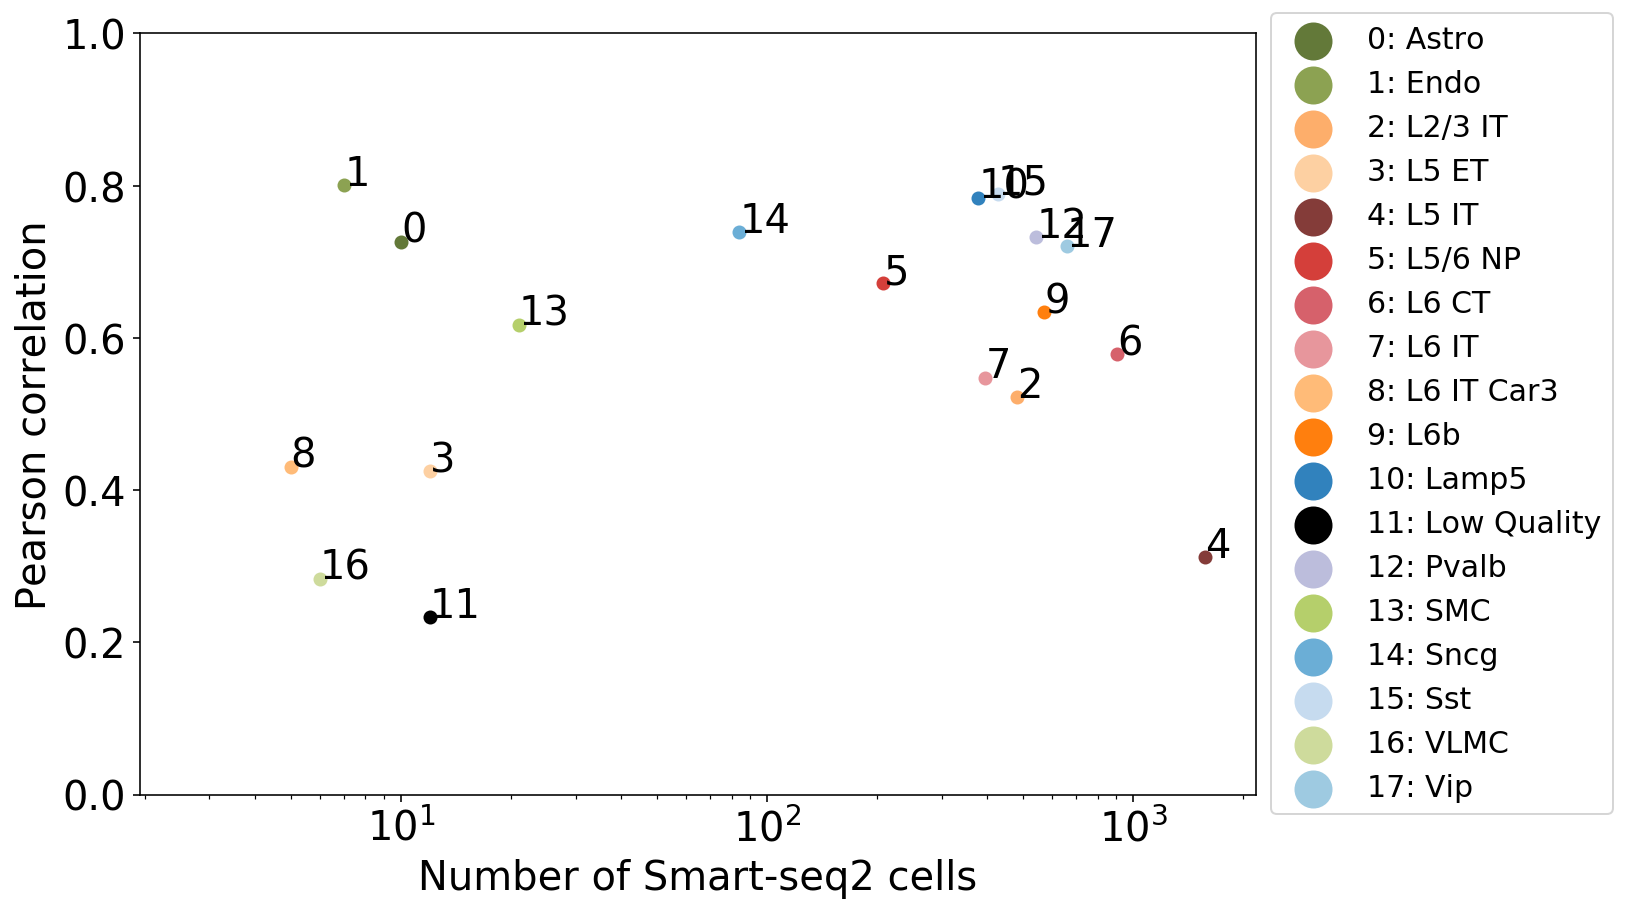

In [91]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = r2

for i, txt in enumerate(unique):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt), color=cluster_cmap[txt])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of Smart-seq2 cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
#plt.savefig("./level_1_fig/10_correlation.png", bbox_inches='tight', dpi=300)
plt.show()

In [100]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

IndexError: list index out of range

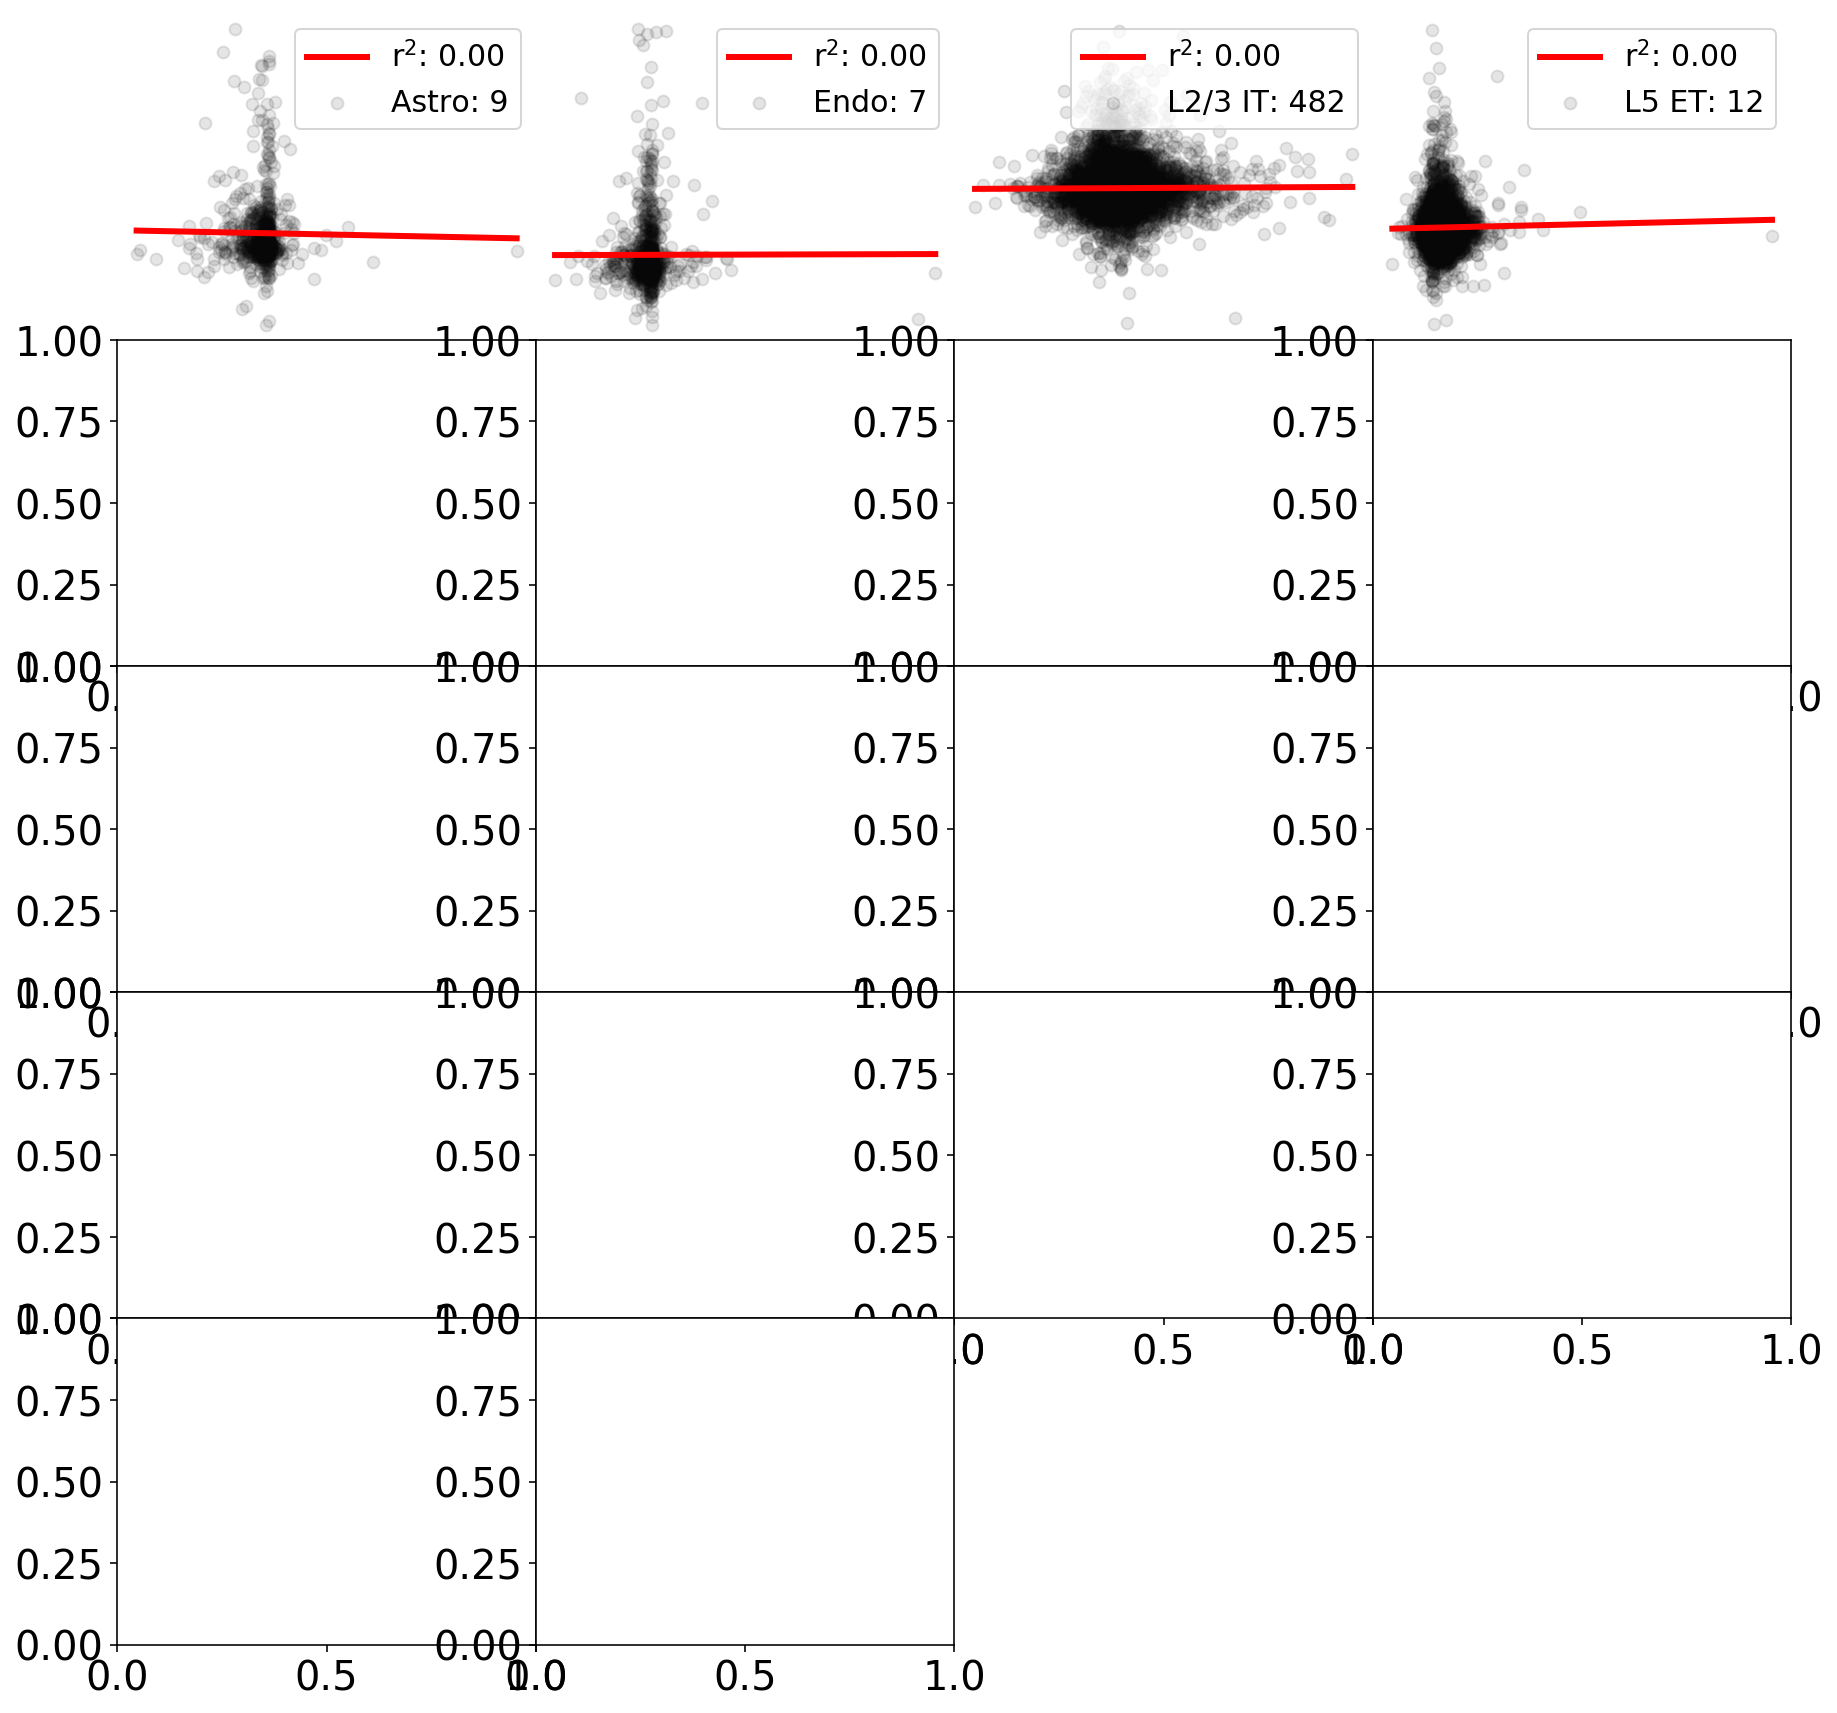

In [101]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=5)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(unique))

for cidx, (ax, c) in enumerate(zip(axs, unique)):
    
    
    x = ss_x[cidx]
    y = tenx_x[cidx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, ss_size[cidx]), color="k", alpha=0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="r$^2$: {:,.2f}".format(r_value**2), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
    if c == "Low Quality":
        ax.set_axis_on()
fig.text(0.5, 0.1, 'Smart-seq2 scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, '10xv3 scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)
#plt.savefig("./additional_figs/10x_correlation.png", bbox_inches='tight',dpi=300)

plt.show()